In [1]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='--num-executors 3 pyspark-shell'
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

conf = SparkConf()
conf.set("spark.app.name", "natasha pritykovskaya ALS app") 

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [3]:
from IPython.display import Image

In [4]:
spark

In [5]:
from pyspark.sql import Row
from pyspark.sql.types import LongType, StringType, StructType, StructField

df = spark.range(0, 10000).toDF("id")

In [6]:
df.show(5)

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+
only showing top 5 rows



## UDF функции

In [7]:
from pyspark.sql.functions import udf

def plus_one(s):
      return s + 1

plus_one_udf = udf(plus_one, LongType())

df.select("id", plus_one_udf("id").alias("plus_one")).show(5)

+---+--------+
| id|plus_one|
+---+--------+
|  0|       1|
|  1|       2|
|  2|       3|
|  3|       4|
|  4|       5|
+---+--------+
only showing top 5 rows



## Pandas UDF

In [8]:
import pandas as pd

from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql.types import LongType

def plus_one(s):
      return s + 1

x = pd.Series(range(10000))

print(plus_one(x)[:10, ])

0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
dtype: int64


In [9]:
plus_one_pandas_udf = pandas_udf(plus_one, returnType=LongType(), functionType=PandasUDFType.SCALAR)

In [10]:
df.select("id", plus_one_pandas_udf("id").alias("plus_one")).show(5)

+---+--------+
| id|plus_one|
+---+--------+
|  0|       1|
|  1|       2|
|  2|       3|
|  3|       4|
|  4|       5|
+---+--------+
only showing top 5 rows



In [11]:
import pyspark.sql.functions as f

@f.pandas_udf(LongType(), PandasUDFType.SCALAR)
def plus_one(s):
      return s + 1

df.select("id", plus_one("id").alias("plus_one")).show(5)

+---+--------+
| id|plus_one|
+---+--------+
|  0|       1|
|  1|       2|
|  2|       3|
|  3|       4|
|  4|       5|
+---+--------+
only showing top 5 rows



In [12]:
import pyspark.sql.functions as f

@f.pandas_udf(LongType())
def plus_one(s):
      return s + 1

df.select("id", plus_one("id").alias("plus_one")).show(5)

+---+--------+
| id|plus_one|
+---+--------+
|  0|       1|
|  1|       2|
|  2|       3|
|  3|       4|
|  4|       5|
+---+--------+
only showing top 5 rows



Как разбивается колонка на несколько pandas.Series это - внутренняя кухня Spark, поэтому результат ваших pandas_udf не должен зависеть от разбиения. 

In [13]:
import pandas as pd
from scipy import stats

@pandas_udf('double')
def cdf(v):
    return pd.Series(stats.norm.cdf(v))

df.withColumn('cumulative_probability', cdf(df.id)).show()

+---+----------------------+
| id|cumulative_probability|
+---+----------------------+
|  0|                   0.5|
|  1|    0.8413447460685429|
|  2|    0.9772498680518208|
|  3|    0.9986501019683699|
|  4|    0.9999683287581669|
|  5|    0.9999997133484281|
|  6|    0.9999999990134123|
|  7|    0.9999999999987201|
|  8|    0.9999999999999993|
|  9|                   1.0|
| 10|                   1.0|
| 11|                   1.0|
| 12|                   1.0|
| 13|                   1.0|
| 14|                   1.0|
| 15|                   1.0|
| 16|                   1.0|
| 17|                   1.0|
| 18|                   1.0|
| 19|                   1.0|
+---+----------------------+
only showing top 20 rows



In [22]:
@pandas_udf(df.schema, PandasUDFType.GROUPED_MAP)
def subtract_mean(pdf):
    return pdf.assign(v=pdf.v - pdf.v.mean())

In [23]:
df = spark.createDataFrame(
    [(1, 1.0), (1, 2.0), (2, 3.0), (2, 5.0), (2, 10.0)],
    ("id", "v"))

In [24]:
df.show()

+---+----+
| id|   v|
+---+----+
|  1| 1.0|
|  1| 2.0|
|  2| 3.0|
|  2| 5.0|
|  2|10.0|
+---+----+



In [25]:
df.groupby('id').apply(subtract_mean).show()

+---+----+
| id|   v|
+---+----+
|  1| 0.5|
|  1|-0.5|
|  2|-3.0|
|  2|-1.0|
|  2| 4.0|
+---+----+



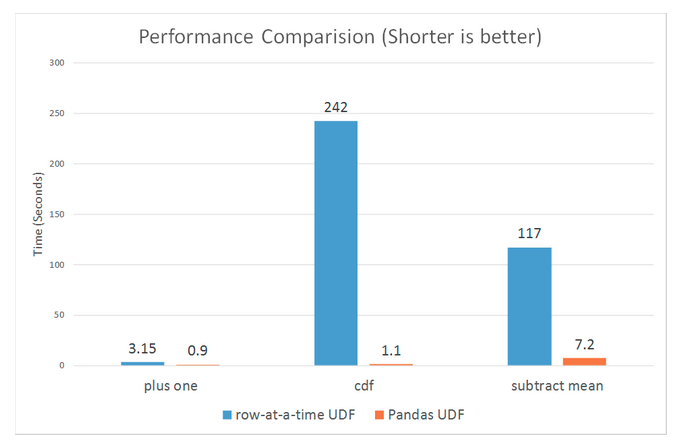

In [26]:
Image("pics/udf_vs_pandas_udf.png")

# Mixins

In [27]:
class Vehicle(object):
    def __init__(self, position):
        self.position = position
        print(position)
        
    def move_along(self):
        pass

class Car(Vehicle):
    pass

class Plane(Vehicle):
    pass

In [32]:
class Radio():
    def play_song(self):
        print("Детка-детка, ты теперь брюнетка.")

class RadioMixin(object):
    def __init__(self):
        self.radio = Radio()
        print("radio")
    
    def play_song(self):
        self.radio.play_song()

class Car(Vehicle, RadioMixin):
    pass

class Clock(Vehicle, RadioMixin):
    pass

In [33]:
car = Car()

TypeError: __init__() missing 1 required positional argument: 'position'

In [34]:
class Car(RadioMixin, Vehicle):
    pass

class Clock(RadioMixin, Vehicle):
    pass

car = Car()
car.play_song()

radio
Детка-детка, ты теперь брюнетка.


In [35]:
class BaseClass1():
    def __init__(self): 
        print("BaseClass1")

class BaseClass2():
    def __init__(self): 
        print("BaseClass2")
    

class MyClass(BaseClass1, BaseClass2):
    def __init__(self): 
        super(MyClass, self).__init__()

In [36]:
my_class = MyClass()

BaseClass1


In [37]:
class BaseClass0():
    def __init__(self): 
        print("BaseClass0")

class BaseClass1(BaseClass0):
    pass

class BaseClass2():
    def __init__(self): 
        print("BaseClass2")
    
class MyClass(BaseClass1, BaseClass2):
    def __init__(self): 
        super(MyClass, self).__init__()

In [38]:
my_class = MyClass()

BaseClass0


In [39]:
class MyClass(BaseClass2, BaseClass1):
    def __init__(self): 
        super(MyClass, self).__init__()

In [40]:
my_class = MyClass()

BaseClass2


In [41]:
spark.stop()